# Подготовка данных и выбор признаков для построения модели

Логистическая регерссия является традиционным статистическим инструментом для расчета коэффициентов скоринговой карты на основе накопленной кредитной истории.

Любая регрессионная модель может быть записана в виде:
$$ y = F(x_1, x_2,...,x_n)$$

Вместо предсказания бинарной переменной, будем предсказывать непрерывную переменную со значением на отрезке [0,1] при любых значениях независимой переменной.

Логит-преобразование:

$$ p = P\{X = 1\} = \frac{1}{1 + e^{-y}} = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + ... + \beta_k x_k)}} $$

$$ y = ln\left( \frac{p}{1-p} \right)$$

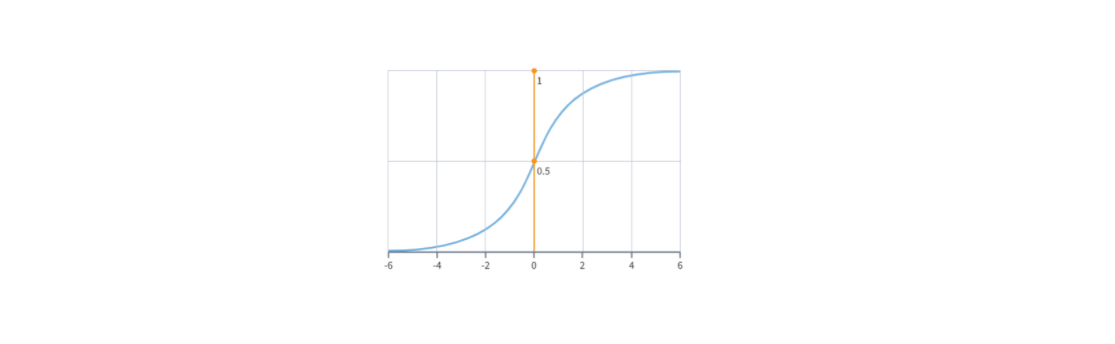

## Импорт библиотек и настройки

In [1]:
import os # библиотека для работы с операционной системой
import numpy as np  # библиотека для поддержки больших многомерных массивов и матриц
import pandas as pd  # библиотека для обработки данных в виде (таблиц) датафреймов
import matplotlib.pyplot as plt # библиотка двумерной графики
import seaborn as sns # библиотка для визуалицаии данных
# функция, которая позволяет отображать графики matplotlib непосредственно в ячейке, где они были сделаны
%matplotlib inline 
import warnings  # библиотека для работы с предупреждениями
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Чтение и подготовка данных

Считаем данные и выведем первые несколько строк таблицы

In [2]:
data_pd = pd.read_csv('FeatureSelection.csv', index_col=0)
data_pd.head() 

,id,vintage_year,monthly_installment,loan_balance,num_bankrupt_iva,time_since_bankrupt,time_since_ccj,ccj_amount,num_bankrupt,num_iva,...,avg_bal_6m,avg_bureau_score_6m,default_flag,woe_max_arrears_12m,woe_bureau_score,woe_cc_util,woe_num_ccj,woe_emp_length,woe_months_since_recent_cc_delinq,woe_annual_income
0,6670001,2005,746.70,131304.44,0.0,0.0,0.0,0.0,0.0,0.0,...,132080.0,542.0,0,0.675750,1.034578,1.852935,0.177302,-0.369946,-0.192033,0.586514
1,9131199,2006,887.40,115486.51,0.0,0.0,0.0,0.0,0.0,0.0,...,116972.0,494.0,0,0.675750,0.770801,-0.470497,0.177302,0.559709,-0.192033,0.586514
2,4963167,2004,1008.50,128381.73,0.0,0.0,36.0,459.0,0.0,0.0,...,128500.0,290.0,1,-2.213109,-0.790017,-0.470497,-0.864667,-0.369946,-0.431236,-1.796272
3,3918582,2005,458.23,35482.96,0.0,0.0,0.0,0.0,0.0,0.0,...,36610.0,460.0,0,0.675750,0.770801,1.852935,0.177302,0.559709,-0.431236,0.246794
4,5949777,2006,431.20,77086.31,0.0,0.0,0.0,0.0,0.0,0.0,...,77518.0,468.0,0,0.675750,0.770801,-2.323441,0.177302,0.559709,-0.431236,0.586514


In [3]:
data_pd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25465 entries, 0 to 25464
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 25465 non-null  int64  
 1   vintage_year                       25465 non-null  int64  
 2   monthly_installment                25465 non-null  float64
 3   loan_balance                       25465 non-null  float64
 4   num_bankrupt_iva                   25465 non-null  float64
 5   time_since_bankrupt                25465 non-null  float64
 6   time_since_ccj                     25465 non-null  float64
 7   ccj_amount                         25465 non-null  float64
 8   num_bankrupt                       25465 non-null  float64
 9   num_iva                            25465 non-null  float64
 10  min_months_since_bankrupt          25465 non-null  float64
 11  pl_flag                            25465 non-null  int

Весомость наблюдения (WOE) - коэффициент, оценивающий дискриминационную способность отдельно взятой переменной.
Наблюдения разбиваются на группы по значениям (если категориальная переменная, то по конкретным зачениям, если колчественная - по интервалам), в каждой группе определяются доли "хороших" и "плохих" заемщиков во всей выборке. 

$$ DistributionGood_i = \frac{N_i^{Good}}{\sum_i N_i^{Good}} $$
$$ DistributionBad_i = \frac{N_i^{Bad}}{\sum_i N_i^{Bad}} $$
$$ WoE_i = ln \frac{DistributionBad_i}{DistributionGood_i} $$

Проверим данные на дубликаты

In [4]:
if any(data_pd.duplicated()):
    print('There are duplicates in data')
else:
    print('Data is ok')

Data is ok


Дубликаты в данных отсутствуют.

Проверим, что столбец 'default_flag' - дефолт заемщика - содержит только 0 и 1:

In [5]:
data_pd['default_flag'].unique() # функция показывает уникальные значения, находящиеся в данных

array([0, 1], dtype=int64)

### Проверим достаточность выборки

Применим правило 20 EPV для того, чтобы оценить максимально возможное количество предикторов в модели.

In [6]:
d = sum(data_pd['default_flag'])
print('Максимально возможное количество предикторов:', ( int(d/ 20)))

Максимально возможное количество предикторов: 66


Посчитаем минимальный объем выборки:

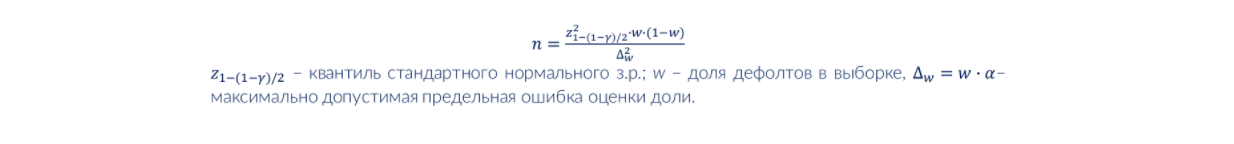

In [7]:
from scipy.stats import norm # библиотека для нахождения квантили нормального распределения
gamma = 0.90 # зададим уровень надежности
alfa = 0.1 # зададим значение максимальной ошибки

n = len(data_pd['default_flag']) # общее кол-во заемщиков
w = d/n
z = norm.ppf(1-(1-gamma)/2) # квантиль нормального распределения  
delta = alfa * w

n_required = (z**2*w*(1-w))/(delta**2)
print('Минимальный объем выборки:', int(n_required))
print('Объем наблюдаемой выборки:', int(n))

Минимальный объем выборки: 4886
Объем наблюдаемой выборки: 25465


Все отлично. Перейдем к следующему шагу. Посмотрим на основные статистики для каждого из показателей (столбцов датафрейма), кроме 'id':

In [8]:
data_pd.iloc[:, 1:].describe() #iloc - обращение к элементам датафрэйма

,vintage_year,monthly_installment,loan_balance,num_bankrupt_iva,time_since_bankrupt,time_since_ccj,ccj_amount,num_bankrupt,num_iva,min_months_since_bankrupt,...,avg_bal_6m,avg_bureau_score_6m,default_flag,woe_max_arrears_12m,woe_bureau_score,woe_cc_util,woe_num_ccj,woe_emp_length,woe_months_since_recent_cc_delinq,woe_annual_income
count,25465.000000,25465.000000,25465.000000,25465.000000,25465.000000,25465.000000,2.546500e+04,25465.000000,25465.000000,25465.000000,...,25465.000000,25465.000000,25465.000000,25465.000000,25465.000000,25465.000000,25465.000000,25465.000000,25465.000000,25465.000000
mean,2005.448851,557.798681,98969.540408,0.047202,2.350756,4.040958,6.388746e+02,0.006440,0.037031,0.327194,...,99784.615276,390.324681,0.052464,0.366963,0.233293,0.873871,0.063273,0.085043,0.216556,0.194354
std,1.314502,310.878336,67201.739437,0.217017,11.329791,13.952894,1.577721e+04,0.079994,0.190292,4.232650,...,67151.743120,108.675575,0.222966,0.760467,0.721444,1.349076,0.337773,0.428209,0.771597,0.579812
min,2001.000000,0.010000,0.200000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,-70.000000,0.000000,-2.213109,-0.790017,-2.323441,-1.112557,-0.727325,-0.431236,-1.796272
25%,2005.000000,373.210000,59034.900000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,59878.000000,306.000000,0.000000,0.675750,-0.790017,-0.470497,0.177302,-0.369946,-0.431236,0.246794
50%,2006.000000,502.800000,85446.080000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,86214.000000,402.000000,0.000000,0.675750,-0.068048,1.852935,0.177302,0.184187,-0.192033,0.246794
75%,2006.000000,677.850000,123679.060000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,124458.000000,482.000000,0.000000,0.675750,1.034578,1.852935,0.177302,0.559709,1.353357,0.586514
max,2015.000000,5181.400000,983843.660000,2.000000,120.000000,120.000000,2.449929e+06,1.000000,2.000000,72.000000,...,983836.000000,706.000000,1.000000,0.675750,1.034578,1.852935,0.177302,0.559709,1.353357,0.586514


## Выбор признаков для дальнейшего анализа

Основные этапы выбора признаков для дальнейшего анализа: 
1. Выбор long list признаков с высокой индивидуальной связью с зависимой переменной;
2. На основе анализа матрицы корреляций отбрасываем сильно скоррелированные друг с другом признаки;
3. Подбираем оптимальную структуру модели (short list).

В качестве зависимой переменной обозначим 'default_flag' - вероятность дефолта заемщика. В качестве независимых (объясняющих) переменных возьмем все остальные столбцы датафрейма.

In [9]:
X = data_pd.drop('default_flag',axis=1) # drop - удалить строку/столбец. Если axis=1, то удаляет столбец, если axis=0 - строку
y = data_pd['default_flag']

### 1. Подготовка long list факторов для построения модели на базе однофакторного анализа

Для однофакторного анализа использовался класс **Feature_selection** из библиотеки sklearn и методы **SelectKBest** + **f_classif**. Метод  f_classif является реализацией ANOVA F-теста. Для создания списка предикторов – кандидатов для включения в модель отсортируем их по F-статистикам в порядке убывания.

Импортируем необходимые библиотеки

In [10]:
from sklearn.feature_selection import SelectKBest, f_classif

Вызовем конструктор

In [11]:
kbest_test = SelectKBest(score_func=f_classif) # создадим экземпляр класса Kbest
kbest_fit = kbest_test.fit(X, y) # вызовем метод fit 

C:\Users\nikit\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Оформим результаты в датафрейм

In [12]:
kbest_res = pd.DataFrame({'col': list(X.columns), 'score': kbest_fit.scores_, 'p-value': kbest_fit.pvalues_})# создаем датафрейм с 2мя колонками - названием предикторов и полученнм значением score
kbest_res = kbest_res.sort_values('score', ascending=False) # отсортируем по убыванию
kbest_res

,col,score,p-value
14,arrears_months,4719.892815,0.000000e+00
17,arrears_segment,3466.467190,0.000000e+00
16,arrears_status,2872.208073,0.000000e+00
32,woe_cc_util,2730.444319,0.000000e+00
30,woe_max_arrears_12m,2673.470091,0.000000e+00
24,worst_arrears_status,2254.000417,0.000000e+00
27,max_mia_6m,2196.935770,0.000000e+00
25,avg_mia_6m,1399.307336,3.466409e-298
36,woe_annual_income,1111.809372,1.212515e-238
29,avg_bureau_score_6m,748.188463,2.211788e-162


Значения NaN появились для тех столбцов, в которых все заемщики имеют одно и то же значение. Не будем рассматривать данные признаки для построения модели

In [13]:
kbest_res = kbest_res.dropna() # Уберем значения NaN
alfa = 0.05 # зададим уровень значимости
kbest_res = kbest_res[kbest_res['p-value'].values<alfa] #уберем незначимые факторы 
kbest_res

,col,score,p-value
14,arrears_months,4719.892815,0.000000e+00
17,arrears_segment,3466.467190,0.000000e+00
16,arrears_status,2872.208073,0.000000e+00
32,woe_cc_util,2730.444319,0.000000e+00
30,woe_max_arrears_12m,2673.470091,0.000000e+00
24,worst_arrears_status,2254.000417,0.000000e+00
27,max_mia_6m,2196.935770,0.000000e+00
25,avg_mia_6m,1399.307336,3.466409e-298
36,woe_annual_income,1111.809372,1.212515e-238
29,avg_bureau_score_6m,748.188463,2.211788e-162


Отобразим на графике полученные scores, чтобы осуществить выбор факторов для дальнейшего анализа

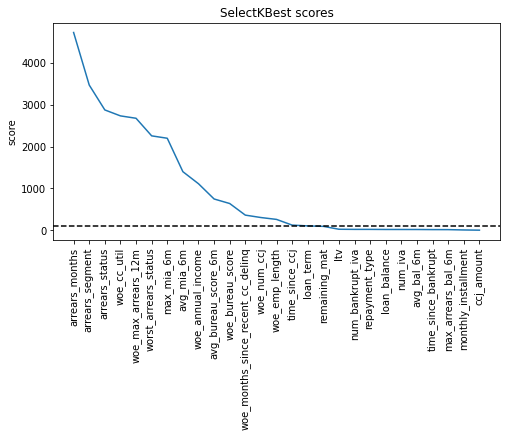

In [14]:
limit = 100 # Зададим минимальное значение для F-score

plt.figure(figsize=(8, 4)) # Зададим размер картинки
plt.plot(kbest_res['col'], kbest_res['score']) # нарисуем график полученных score для каждого из предикторов
plt.axhline(y=limit, color='black', linestyle='--') # выделим уровень на графике для значения limit
plt.title('SelectKBest scores')# зададим название графика
plt.ylabel('score')  # зададим название вертикальной оси
plt.xticks(rotation=90) # повернем надписи по горизонтальной оси влево на 90 градусов
plt.show(); # покажем график

Выберем в качестве граничного значения score 100, тогда следующие факторы попадают в long list факторов для модели

In [15]:
long_lst = kbest_res['col'][kbest_res['score']>=limit].tolist() #выберем те предикторы, для которых score>=limit

In [16]:
long_lst

['arrears_months',
 'arrears_segment',
 'arrears_status',
 'woe_cc_util',
 'woe_max_arrears_12m',
 'worst_arrears_status',
 'max_mia_6m',
 'avg_mia_6m',
 'woe_annual_income',
 'avg_bureau_score_6m',
 'woe_bureau_score',
 'woe_months_since_recent_cc_delinq',
 'woe_num_ccj',
 'woe_emp_length',
 'time_since_ccj',
 'loan_term']

В long list включаем 16 переменных с 𝑝𝑣𝑎𝑙𝑢𝑒 < 0,05 и значением F-статистики выше 100 (порог установлен экспертно).

### 2. Матрица корреляций

В рамках валидации модели рассчитываются коэффициенты корреляции Пирсона. При оценке степени корреляции переменных применяются следующие критерии:
- <font color=green>𝑐𝑜𝑟𝑟 ≤ 35% - «зеленая зона»</font>;
- <font color=orange>35% < 𝑐𝑜𝑟𝑟 ≤ 70%- «оранжевая зона»</font>;
- <font color=red>𝑐𝑜𝑟𝑟 > 70% - «красная зона»</font>.

Высокое значение корреляции между предикторами модели может свидетельствовать о наличии мультиколлинеарности, которая приводит к некорректной оценке весов параметров модели.

**Для переменных, попавших в список 16 предикторов – кандидатов для включения в модель (long list) по результатам однофакторного анализа, проводится корреляционный анализ. Для каждой пары факторов с высокой корреляцией (>70%) из списка исключается фактор с меньшим значением F-статистики.**

Рассчитаем попарные корреляции для факторов, попавших в long list

In [17]:
corr_data = X[long_lst] # выберем данные для рассчета корреляции (long list) 

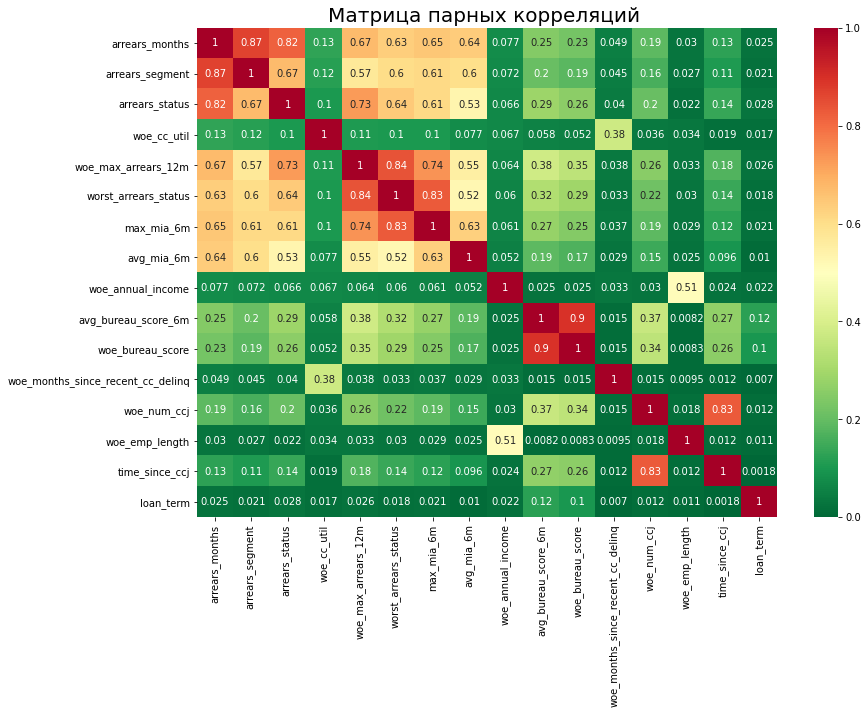

In [18]:
plt.figure(figsize=(13, 9)) # зададим размер картинки
corr_data = corr_data.corr() # рассчитаем корреляцию
sns.heatmap(abs(corr_data), cmap=plt.cm.RdYlGn_r, vmin=0, vmax=1, annot = True) # нарисуем график
plt.title('Матрица парных корреляций ', fontsize=20); # зададим название графика

Анализ матрицы корреляций показывает, что следующие факторы являются сильно зависимыми: 'arrears_month', 'arrears_status', их нужно исключить из рассмотрения.

Для каждой пары сильно скоррелированных предикторов нужно выбрать только один предиктор с наибольшим значением F-статистики:
- 'woe_max_arrears_12m' сильно скоррелирован с 'worst_arrears_status'. Значение F-статистики выше для 'woe_max_arrears_12m', поэтому исключим 'worst_arrears_status';
- 'worst_arrears_status' - с 'max_mia_6m' - исключим 'max_mia_6m';
- 'woe_bureau_score' - с 'avg_bureau_score_6m' - исключим 'woe_bureau_score';
- 'woe_num_ccj' - с 'time_since_ccj' - исключим 'time_since_ccj'.

Перейдем к подготовке short list факторов для построения модели

In [19]:
lst_to_delete = ['arrears_months', 'arrears_status', 'worst_arrears_status', 'max_mia_6m', 
                 'woe_bureau_score', 'time_since_ccj'] # список названий факторов для исключения

In [20]:
short_lst = [elem for elem in long_lst if elem not in lst_to_delete] # сформируем short list

**После исключения факторов на базе корреляционного анализа получили следующий список из 10 предикторов для включения в модель :**


In [21]:
short_lst

['arrears_segment',
 'woe_cc_util',
 'woe_max_arrears_12m',
 'avg_mia_6m',
 'woe_annual_income',
 'avg_bureau_score_6m',
 'woe_months_since_recent_cc_delinq',
 'woe_num_ccj',
 'woe_emp_length',
 'loan_term']

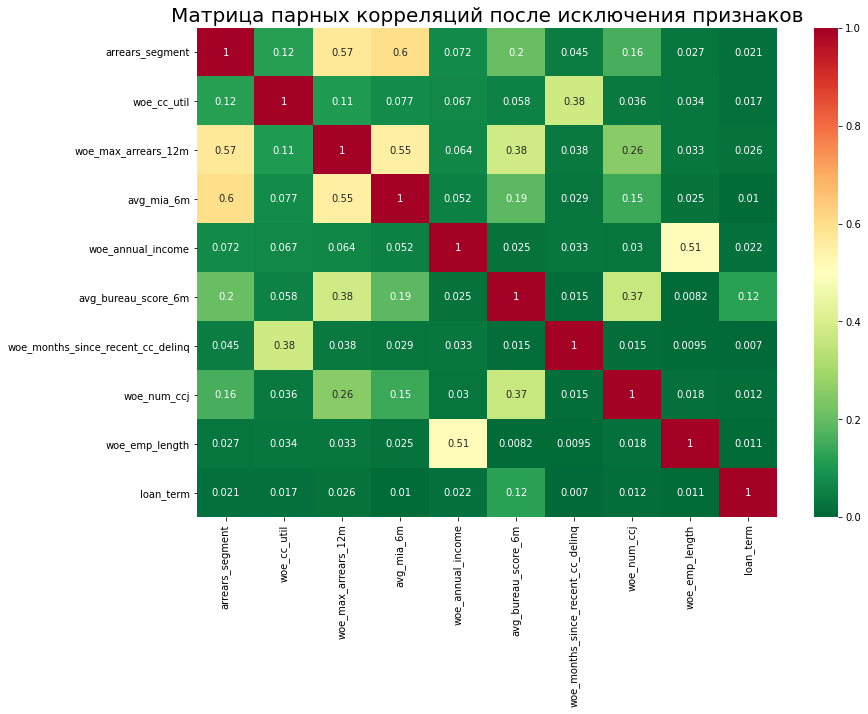

In [22]:
plt.figure(figsize=(13, 9))# зададим размер картинки
corr_data_cleaned = X[short_lst].corr()# рассчитаем корреляцию
sns.heatmap(abs(corr_data_cleaned), cmap=plt.cm.RdYlGn_r, vmin=0, vmax=1, annot = True)  # нарисуем график
plt.title('Матрица парных корреляций после исключения признаков', fontsize=20); # зададим название графика

### 3. Подготовка финального списка факторов

Для подготовки финального списка предикторов используем Recursive Feature Elimination (RFE) из библиотеки sklearn

**Метод ранжирования с рекурсивным устранением объектов (RFE)** позволяет выбрать признаки путем рекурсивного рассмотрения все меньших и меньших наборов данных. Сначала выбранная модель (в нашем случае логистическая регрессия) обучается на начальном наборе данных, при этом оценивается важность каждого признака. Затем наименее важные признаки отсекаются. Эта процедура рекурсивно повторяется на обрезанном наборе данных до тех пор, пока не будет достигнуто желаемое количество объектов для выбора.

Импортируем необходимые библиотеки

In [23]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

Зададим финальное количество признаков, которое будем использовать для построения модели

In [24]:
n_regressors = 7

Вызовем конструктор для создания модели логистической регресии и передадим его в качестве аргументов для выбора признаков:

In [25]:
logreg = LogisticRegression()
rfe = RFE(logreg, n_features_to_select=n_regressors) # метод RFE принимает на вход конструктор (вид модели), и финальное кол-во факторов. По умолчанию n_features_to_select=None и отбирается половина факторов 
rfe = rfe.fit(X[short_lst], y)

Проверим количество выбранных селектором признаков:

In [26]:
print(rfe.n_features_)

7


Получим маску для выбранных признаков. Маска - присвоение значения True для выбранных факторов и False для не выбранных 

In [27]:
selected_features = rfe.support_
print(selected_features)

[ True  True  True  True  True False  True  True False False]


Посмотрим на ранги признаков (от 1 - наиболее подходящего для модели признака по возрастанию)

In [28]:
print(rfe.ranking_)

[1 1 1 1 1 4 1 1 2 3]


Посмотрим на названия выбранных признаков

In [29]:
final_lst = X[short_lst].loc[:, selected_features].columns.tolist()
# X[short_lst] - из датафрейма Х выбираем колонки с названиями из short list
# .loc[:, selected_features] - из сформированного датафрейма выбираем колонки для которых значение в selected_features=True
# .columns.tolist() - берем названия колонок и записываем в лист

final_lst

['arrears_segment',
 'woe_cc_util',
 'woe_max_arrears_12m',
 'avg_mia_6m',
 'woe_annual_income',
 'woe_months_since_recent_cc_delinq',
 'woe_num_ccj']

# Построение модели

**Для построения модели логистической регрессии в Python существует две различных библиотеки:**
- **statsmodels. Чаще используется для статистических целей, так как обладает широким набором статистических тестов**
- **sklearn. Чаще используется для реализации методов машинного обучения. Направлена на решение задач классификации, включает наиболее распространенные метрики, не отличается большим набором статистических тестов.**

**В данном примере показано, что обе библиотеки равноправны, дают одинаковый результат и выбор библиотеки производится с учетом целей пользователя**    



### Построим модель с использованием библиотеки statsmodels

In [30]:
data_pd = pd.read_csv('ModelData.csv', index_col=0)
data_pd.head()

,woe_max_arrears_12m,woe_bureau_score,woe_cc_util,woe_num_ccj,woe_emp_length,woe_months_since_recent_cc_delinq,woe_annual_income,default_flag
0,0.675750,1.034578,1.852935,0.177302,-0.369946,-0.192033,0.586514,0
1,0.675750,0.770801,-0.470497,0.177302,0.559709,-0.192033,0.586514,0
2,-2.213109,-0.790017,-0.470497,-0.864667,-0.369946,-0.431236,-1.796272,1
3,0.675750,0.770801,1.852935,0.177302,0.559709,-0.431236,0.246794,0
4,0.675750,0.770801,-2.323441,0.177302,0.559709,-0.431236,0.586514,0


In [31]:
import statsmodels.api as sm # импортируем библиотеку

X_sm = data_pd.drop('default_flag', axis=1).copy() # сформируем датафрейм независимых переменных путем копирования исходного датафрейма с удаленным столбцом "default_flag"
y_sm = data_pd['default_flag'].copy() #зависимая переменная
X_sm['intercept'] = 1 # добавим единичный столбец, чтоб оценить коэффициент пересечения

model = sm.Logit(y_sm, X_sm, intercept=True)  # построим модель логистической регрессии
model_result = model.fit() # оценим параметры модели
print(model_result.summary2()) # выведем результаты


Optimization terminated successfully.
         Current function value: 0.125979
         Iterations 9
                                  Results: Logit
Model:                    Logit                  Pseudo R-squared:       0.388    
Dependent Variable:       default_flag           AIC:                    6432.1183
Date:                     2021-02-22 15:49       BIC:                    6497.2787
No. Observations:         25465                  Log-Likelihood:         -3208.1  
Df Model:                 7                      LL-Null:                -5238.4  
Df Residuals:             25457                  LLR p-value:            0.0000   
Converged:                1.0000                 Scale:                  1.0000   
No. Iterations:           9.0000                                                  
----------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------

### Построим модель с использованием библиотеки sklearn

In [32]:
from sklearn.linear_model import LogisticRegression # импортируем из библиотеки sklearn класс для построения моделей лог.регрессии

X = data_pd.drop('default_flag', axis=1).copy() # сформируем датафрейм независимых переменных путем копирования исходного датафрейма с удаленным столбцом "default_flag"
y = data_pd['default_flag'].copy() #зависимая переменная

logreg = LogisticRegression(C=1e9, fit_intercept=True) # построим модель логистической регрессии
logreg.fit(X, y) #оценка параметров модели

# Выведем коэффициенты модели и пересечение
print('Коэффициенты модели:', logreg.coef_)
print('Пересечение:', logreg.intercept_)
 

Коэффициенты модели: [[-0.80830606 -0.52850994 -0.94134367 -0.06250825 -0.14203597 -0.30522203
  -0.95178053]]
Пересечение: [-2.89366744]


Ожидаемо результаты совпадают.

# Проверка допущений (assumptions) модели

## 1. Проверка значимости коэффициентов логистической регрессии и уравнения модели

**Цель Теста** Проверка значимости полученных коэффициентов модели, всего уравнения в целом.

**Описание теста** Для проверки значимости коэффициентов используется тест Вальда, всего уравнения в целом – Тест отношения правдоподобий 

In [33]:
model_result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Results: Logit
==================================================================================
Model:                    Logit                  Pseudo R-squared:       0.388    
Dependent Variable:       default_flag           AIC:                    6432.1183
Date:                     2021-02-22 15:49       BIC:                    6497.2787
No. Observations:         25465                  Log-Likelihood:         -3208.1  
Df Model:                 7                      LL-Null:                -5238.4  
Df Residuals:             25457                  LLR p-value:            0.0000   
Converged:                1.0000                 Scale:                  1.0000   
No. Iterations:           9.0000                                                  
----------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------
woe_max_arrears_12m               -0.8083   0.0323 -25.0608 0.0000 -0.8715 -0.7451
woe_bureau_score                  -0.5285   0.0539  -9.7968 0.0000 -0.6342 -0.4228
woe_cc_util                       -0.9413   0.0291 -32.3267 0.0000 -0.9984 -0.8843
woe_num_ccj                       -0.0625   0.0822  -0.7597 0.4474 -0.2237  0.0987
woe_emp_length                    -0.1420   0.0898  -1.5805 0.1140 -0.3181  0.0341
woe_months_since_recent_cc_delinq -0.3052   0.0694  -4.4003 0.0000 -0.4412 -0.1693
woe_annual_income                 -0.9518   0.0506 -18.8218 0.0000 -1.0509 -0.8527
intercept                         -2.8936   0.0410 -70.5998 0.0000 -2.9740 -2.8133
==================================================================================

"""

В столбце таблицы $P>|z|$ можно увидеть значения p-value для каждого из коэффициентов модели. Значение p-value для теста правдоподобий можно увидеть вверху таблицы LLR p-value

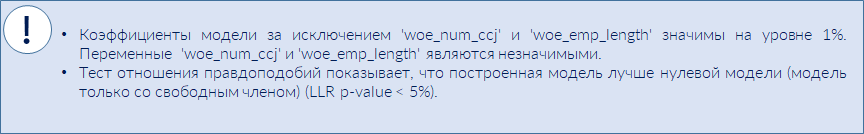

## 2. Проверка мультиколлинеарности признаков

Мультиколлинеарность тестируется для всех входных переменных в модели с помощью теста Variance Inflation Factor (VIF). Нет никакого акцента на VIF как на конкретное число. Он должен использоваться для руководства последующими испытаниями на модели с определенной переменной или без нее. Более высокий VIF является показателем более высокой мультиколлинеарности. VIF выше 5 считается большим.

**Цель теста** Проверить отсутствие линейной зависимости между объясняющими переменными (факторами) модели

**Описание теста** Для проверки наличия мультиколлинеарности рассчитывают Variance Inflation Factor (VIF). VIF выше 5 считается большим

In [34]:
from statsmodels.stats.outliers_influence import variance_inflation_factor # Вызовем функцию для расчета VIF
vif = pd.DataFrame() # создадим пустой датафрейм для записи значений
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])] # посчитаем VIF для каждого фактора
vif.index =  X.columns #переименуем индекс в соответсвии с названиями независимых переменных
vif

,VIF Factor
woe_max_arrears_12m,1.366978
woe_bureau_score,1.347836
woe_cc_util,1.407411
woe_num_ccj,1.203279
woe_emp_length,1.402603
woe_months_since_recent_cc_delinq,1.257110
woe_annual_income,1.469985


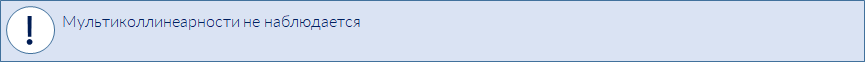

# Оценка качества построенной модели

### Разделим выборку на тестовую и тренировочную

In [35]:
#имортируем функцию, позволяющую делить выборку на тестовую и тренировочную в случайном порядке:
from sklearn.model_selection import train_test_split 

#Аргументы функции:
# X-датафрейм независимых переменных
# y - зависимая переменная
# test_size - размер тестовой выборки в %
# random_state - начальная точка генератора случайных чисел. Для воспроизведения результата необходимо указать любое число.

# Результат работы функции:
# X_train - датафрейм независимых переменных тренировочная выборка
# X_test - датафрейм независимых переменных тестовая выборка
# y_train - зависимая переменная тренировочная выборка
# y_test - зависимая переменная тестовая выборка

In [36]:
#Разделим выборку на тестовую и тренировочную
X_train, X_test, y_train, y_test = train_test_split(data_pd.drop('default_flag', axis=1), 
                                                    data_pd['default_flag'], test_size=.3, 
                                                    random_state=2122)

### Проверим, насколько равномерно разделены данные с дефолтами заемщиков и без дефолтов по выборкам

**Цель теста** Проверить равномерность разделения данных на тестовую и тренировочную выборки

**Описание теста** Расчитаем соотношения доли дефолтов в тестовой и тренировочной выборках. Если соотношение одинаковое -  данные разделены удовлетворительно

In [37]:
# посмотрим сколько дефолтных и недефолтных наблюдений в тренировочной выборке
# функция value_counts() считает кол-во элементов каждого уникального значения в выборке
y_train.value_counts() 

0    16883
1      942
Name: default_flag, dtype: int64

In [38]:
# Расчитаем соотношение доли дефолтов в процентах, для этого поделим кол-во дефолтов на общее кол-во наблюдений:
w_train = (y_train.value_counts()[1] / y_train.value_counts().sum()) * 100
# round() позволяет округлить результат. Указывая вторым аргументом "2" получим округление до 2го значка после запятой
print('Доля дефолтов в тренировочной выборке:', round(w_train, 2), '%')

Доля дефолтов в тренировочной выборке: 5.28 %


In [39]:
# посмотрим сколько дефолтных и недефолтных наблюдений в тестовой выборке
# функция value_counts() считает кол-во элементов каждого уникального значения в выборке
y_test.value_counts()

0    7246
1     394
Name: default_flag, dtype: int64

In [40]:
# Расчитаем соотношение доли дефолтов в процентах, для этого поделим кол-во дефолтов на общее кол-во наблюдений:
w_test = (y_test.value_counts()[1] / y_test.value_counts().sum()) * 100
# round() позволяет округлить результат. Указывая вторым аргументом "2" получим округление до 2го значка после запятой
print('Доля дефолтов в тестовой выборке:', round(w_test, 2), '%')

Доля дефолтов в тестовой выборке: 5.16 %


In [41]:
# Расчитаем соотношение доли дефолтов в полной выборке:
w = data_pd[data_pd.default_flag == 1]['default_flag'].sum() / data_pd.shape[0] * 100
print('Доля дефолтов в полной выборке:', round(w, 2), '%')

Доля дефолтов в полной выборке: 5.25 %


Обе выборки, как и в целом датасет, содержат около 5% дефолтов.

### Проверим выполнение предположений для тренировочной выборки

#### 1. Проверка значимости коэффициентов логистической регрессии и уравнения модели

Построим модель логистической регрессии на тренировочной выборке:

In [42]:
X_train_sm = X_train.copy() # скопируем датафрейм

X_train_sm['intercept'] = 1 # добавим единисный столбец, чтоб оценить коэффициент пересечения
model = sm.Logit(y_train, X_train_sm, intercept=True)  # построим модель
model_result = model.fit() # оценка параметров модели
print(model_result.summary2()) # выведем результаты

Optimization terminated successfully.
         Current function value: 0.125932
         Iterations 9
                                  Results: Logit
Model:                    Logit                  Pseudo R-squared:       0.391    
Dependent Variable:       default_flag           AIC:                    4505.4581
Date:                     2021-02-22 15:50       BIC:                    4567.7650
No. Observations:         17825                  Log-Likelihood:         -2244.7  
Df Model:                 7                      LL-Null:                -3686.5  
Df Residuals:             17817                  LLR p-value:            0.0000   
Converged:                1.0000                 Scale:                  1.0000   
No. Iterations:           9.0000                                                  
----------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------

#### 2. Проверка мультиколлинеарности признаков 

In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor # Вызовем функцию для расчета VIF
vif = pd.DataFrame() # создадим пустой датафрейм для записи значений
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])] # посчитаем VIF для каждого фактора
vif.index =  X.columns #переименуем индекс в соответсвии с названиями независимых переменных
vif

,VIF Factor
woe_max_arrears_12m,1.370006
woe_bureau_score,1.350822
woe_cc_util,1.410785
woe_num_ccj,1.202571
woe_emp_length,1.405597
woe_months_since_recent_cc_delinq,1.259604
woe_annual_income,1.474191


## 1. Дискриминационная способность

### Матрица ошибок (confusion matrix) 

**Матрица ошибок (confusion matrix)** — это таблица, которая позволяет визуализировать эффективность алгоритма классификации путем сравнения прогнозного значения целевой переменной с ее фактическим значением. Столбцы матрицы представляют наблюдения в фактическом классе, а строки — наблюдения в прогнозируемом классе.


In [44]:
from sklearn.metrics import confusion_matrix # функция расчета матрицы ошибок

In [45]:
y_pred = logreg.predict(X_test) # прогноз
confusion_matrix_logreg = confusion_matrix(y_test, y_pred) # Посчитаем матрицу ошибок
confusion_matrix_logreg # посмотрим на матрицу ошибок

array([[7183,   63],
       [ 281,  113]], dtype=int64)

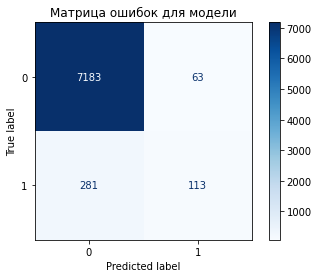

In [46]:
from sklearn.metrics import plot_confusion_matrix # функция для визуализации матрицы ошибок
matrix = plot_confusion_matrix(logreg, X_test, y_test, cmap=plt.cm.Blues) # нарисуем матрицу ошибок
plt.title('Матрица ошибок для модели') # зададим название графика
plt.show(matrix) # отобразим график


### Метрики качества классификации

In [47]:
from sklearn.metrics import classification_report # функция для расчета метрик качества классификации

In [48]:
print(classification_report(y_test, y_pred)) # выведем рассчитанные метрики качества

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      7246
           1       0.64      0.29      0.40       394

    accuracy                           0.95      7640
   macro avg       0.80      0.64      0.69      7640
weighted avg       0.95      0.95      0.95      7640



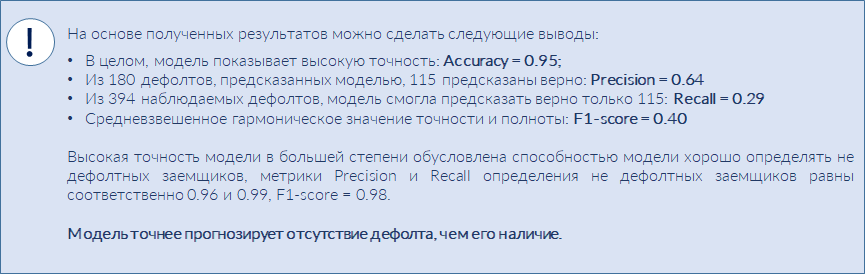

### ROC-кривая и AUROC

In [49]:
from sklearn.metrics import roc_auc_score # Функция для рассчета AUROC
from sklearn.metrics import roc_curve # Функция для построения ROC-кривой

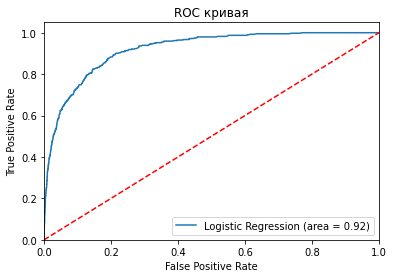

In [50]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1]) # Расчет AUROC. На вход подаются наблюдаемые значения тестовой выборки и прогнозные
#logreg.predict_proba возвращает массив вероятностей принадлежности к каждому классу. Т.е. первый столбец - это вероятность того что у=0, второй - у=1
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1]) # Построение ROC- кривой
plt.figure() # создадим график
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc) #отобразим на графике ROC-кривую и значение AUROC
plt.plot([0, 1], [0, 1],'r--') # отобразим на графике ROC-кривую для случайной модели
plt.xlim([0.0, 1.0]) # ограничим отображение оси х на интервале [0,1] для удобной визуализации
plt.ylim([0.0, 1.05])# ограничим отображение оси y на интервале [0,1.05] для удобной визуализации
plt.xlabel('False Positive Rate') # название оси х
plt.ylabel('True Positive Rate') # название оси y
plt.title('ROC кривая')# название графика
plt.legend(loc="lower right") # расположение легенды
plt.savefig('Log_ROC') # сохранить график
plt.show(); # отобразитьграфик

**Качество модели рассматривается как "отличное", так как AUROC = 0.9, Accuracy = 0.95**

### Коэффициент Джини

Расчитаем коэффициент Джини:

In [51]:
gini = 2 * logit_roc_auc - 1
print('Коэффициент Джини:', round(gini,2))

Коэффициент Джини: 0.84


**Значение коэффициента Джини = 0.84 говорит о хорошем качестве модели**

### Кросс-валидация

Данные делятся на g наборов. Затем модель обучается на g -1 наборах и тестируется на оставшемся наборе. Это повторяется для всех возможных комбинаций, в результате чего получается распределение оценки производительности (например, AUC, индекс Джини).


In [52]:
from sklearn.model_selection import cross_val_score # импорт функции для проведения кросс-валидации

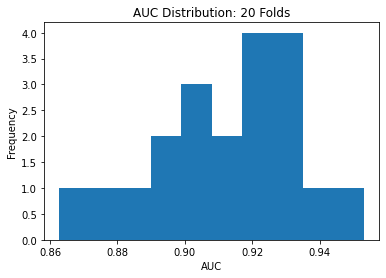

In [53]:
scores = cross_val_score(logreg, X_train, y_train, cv=20, scoring='roc_auc') # вызов функции, в качестве аргументов предеются:
#logreg - построенная модель
#cv - количество наборов g
#scoring - метрика, которая рассчитывается для каждой полученной модели

plt.figure() # создадим график
plt.hist(scores) # нарисуем гистограмму полученных значений AUROC
plt.xlabel('AUC') # название оси х
plt.ylabel('Frequency')# название оси у
plt.title('AUC Distribution: 20 Folds') # название графика
plt.show();# отображение графика

Распределение полученных значений AUC представлено на гистограмме

**Перекрестная проверка результата по AUC (меньше 0,9) переводит модель в класс с качеством «очень хорошо»**

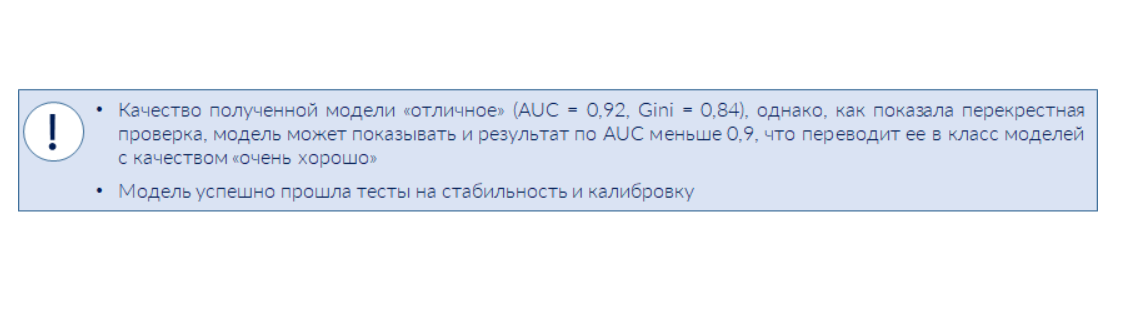